# Random Matrix Simulation

In what follows, we simulate the behaviour of the RG of the stochastic field theory around the Marchenko–Pastur (MP) distribution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [17]:
import numpy as np
from matplotlib import pyplot as plt
from pde import CartesianGrid, MemoryStorage, ScalarField

plt.style.use('ggplot')

from ssd import (SSD,
                 InterpolateDistribution,
                 MarchenkoPastur,
                 TranslatedInverseMarchenkoPastur)
from ssd.utils.matrix import create_bulk, create_signal


## Functional Renormalization Group

We here simulate the behaviour of the functional RG.

In [6]:
# Parameters of the distribution
rows = 10000
ratio = 0.8
a = 0.4
mu = [0.0, 1.0, 0.0]
rank = 2500
beta = 0.8
nbins = 100
xinf = 0.0
xsup = 1.0
nval = 1000
nsteps = 500
smooth = 0.3
seed = 42


We then simulate a signal and a noise distributions:

In [7]:
# Create the components of the matrix
Z = create_bulk(rows=rows, ratio=ratio, random_state=seed)
S = create_signal(rows=rows, ratio=ratio, rank=rank, random_state=seed)

# Compute the full matrix and its covariance
X = Z + beta*S
C = np.cov(X, rowvar=False)

# List the eigenvalues and their inverse (momenta of the distribution)
E = np.linalg.eigvalsh(C)
E_inv = np.flip(1 / E)
E_inv -= E_inv.min()  # remove the mass scale


We then visualize the corresponding Marchenko-Pastur distribution:

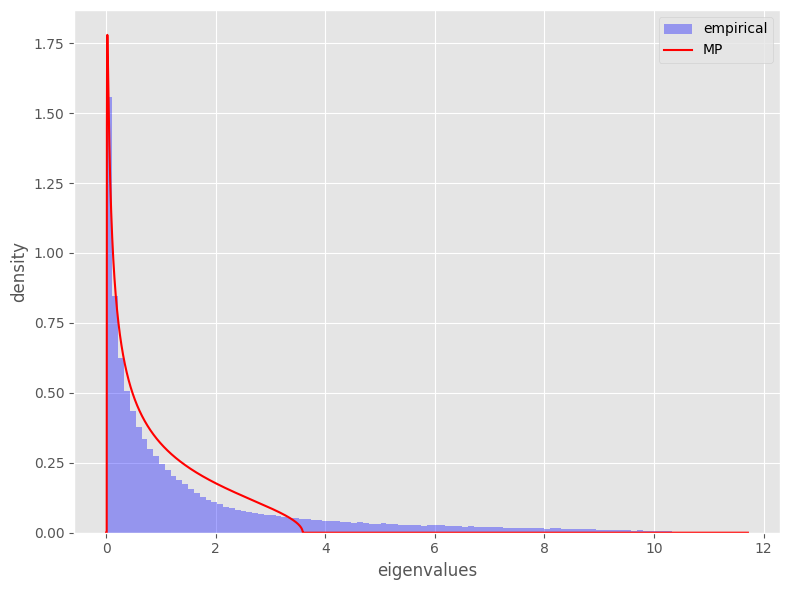

In [10]:
# Plot the Marchenko-Pastur distribution
mp = MarchenkoPastur(L=ratio)
x = np.linspace(0, E.max() * 1.1, num=10000)
y_0 = np.array([mp(xi) for xi in x])

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(E, bins=nbins, density=True, color='b', alpha=0.35, label='empirical')
ax.plot(x, y_0, 'r-', label='MP')
ax.set_xlabel('eigenvalues')
ax.set_ylabel('density')
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)


We then show the inverse distribution for reference:

/tmp/ipykernel_55962/1442314094.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


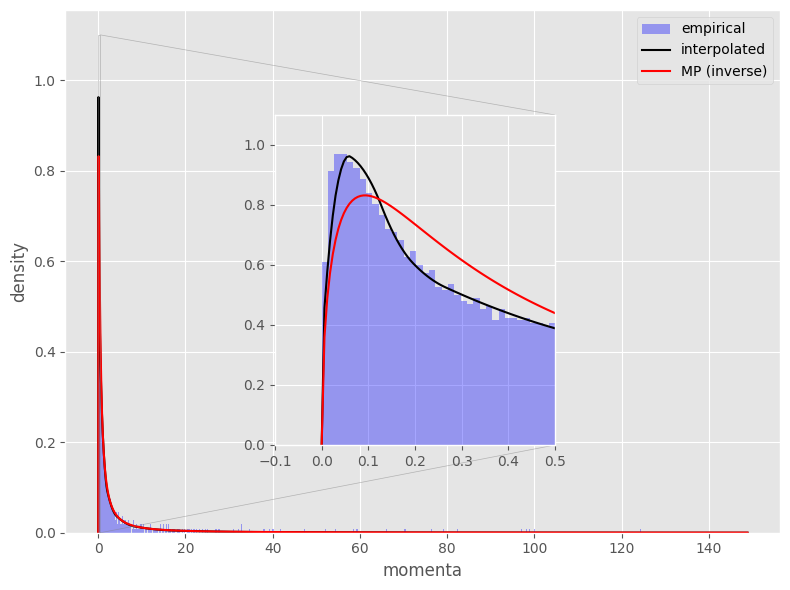

In [18]:
# Plot the inverse Marchenko-Pastur distribution
mp_inv = TranslatedInverseMarchenkoPastur(L=ratio)
dist = InterpolateDistribution(bins=nbins**2)  # empirical distribution
dist = dist.fit(E_inv, n=2, s=smooth, force_origin=True)
x = np.linspace(0, E_inv.max() * 1.1, num=25000)
y_dist = np.array([dist(xi) for xi in x])
y_0 = np.array([mp_inv(xi) for xi in x])

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(E_inv,
        bins=nbins**2,
        density=True,
        color='b',
        alpha=0.35,
        label='empirical')
ax.plot(x, y_dist, 'k-', label='interpolated')
ax.plot(x, y_0, 'r-', label='MP (inverse)')

ax_ins = fig.add_axes([0.35, 0.25, 0.35, 0.55])
ax_ins.set_xlim([-0.1, 0.5])
ax_ins.set_ylim([0.0, 1.1])
ax_ins.hist(E_inv,
            bins=nbins**2,
            density=True,
            color='b',
            alpha=0.35,
            label='empirical')
ax_ins.plot(x, y_dist, 'k-', label='interpolated')
ax_ins.plot(x, y_0, 'r-', label='MP (inverse)')

ax.indicate_inset_zoom(ax_ins)
ax.set_xlabel('momenta')
ax.set_ylabel('density')
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)


We finally look for the _noise_ mass scale at the given signal-to-noise ratio:

In [15]:
# Find the mass scale of the noise
mass_scale = (E >= mp.max).argmax()
mass_scale_bottom = (E >= mp.max + a).argmax()
mass_scale_top = (E >= mp.max - a).argmax()

mass_scale = E_inv[-mass_scale]
mass_scale_bottom = E_inv[-mass_scale_bottom]
mass_scale_top = E_inv[-mass_scale_top]


## Simulation

We can finally simulate the evolution of the FRG equation:

In [19]:
# Define the grid
grid = CartesianGrid(
    [[xinf, xsup]],  # range of x coordinates
    [nval],  # number of points in x direction
    periodic=False,  # periodicity in x direction
)
expression = f'{mu[0]} + {mu[1]} * x + {mu[2]} * x**2'
state = ScalarField.from_expression(grid, expression)  # initial state
bc = 'auto_periodic_neumann'

# Initialize a storage
t_range = [np.sqrt(mass_scale_bottom), np.sqrt(mass_scale_top)]
dt = (t_range[1] - t_range[0]) / nsteps
dt_viz = dt * nsteps / 5
storage = MemoryStorage()
storage_viz = MemoryStorage()
trackers = [
    'progress',
    'steady_state',
    storage.tracker(interval=dt),
    storage_viz.tracker(interval=dt_viz),
]

# Define the PDE and solve
eq = SSD(dist=dist, noise=0.0, bc=bc)
_ = eq.solve(state, t_range=t_range, dt=dt, tracker=trackers)


100%|██████████| 0.4688612525484615/0.4688612525484615 [00:01<00:00, 20.32s/it]      


## Visualisation

We finally visualise the results, as functions of the stochastic time.

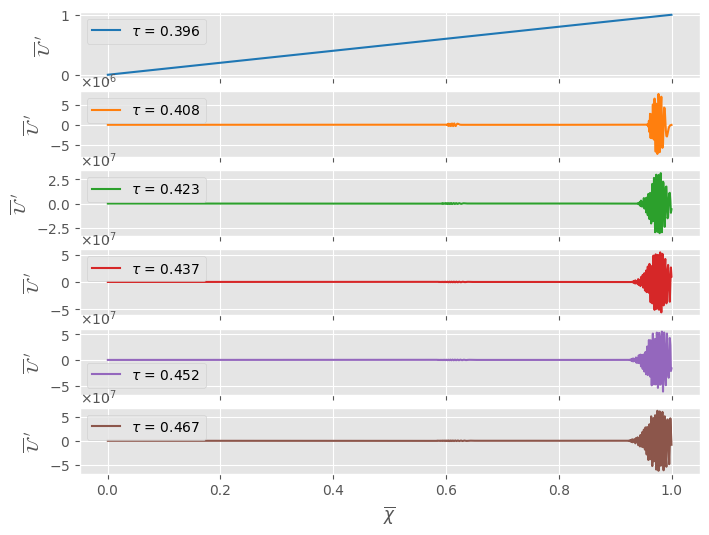

In [21]:
# Visualize the simulation at fixed time steps
fig, ax = plt.subplots(nrows=len(storage_viz), figsize=(8, 6), sharex=True)
cmap = plt.get_cmap('tab10')
for n, (time, field) in enumerate(storage_viz.items()):

    # Collect data
    x = field.grid.axes_coords[0]
    y_0 = field.data

    # Plot the field
    ax[n].plot(x, y_0, color=cmap(n), label=rf'$\tau$ = {time:.3f}')
    ax[n].set_xlabel(r'$\overline{\chi}$')
    ax[n].set_ylabel(r'$\overline{\mathcal{U}}^{~\prime}$')
    ax[n].legend(loc='best')
    ax[n].ticklabel_format(axis='y',
                           style='sci',
                           scilimits=(0, 0),
                           useMathText=True)
plt.show()
plt.close(fig)


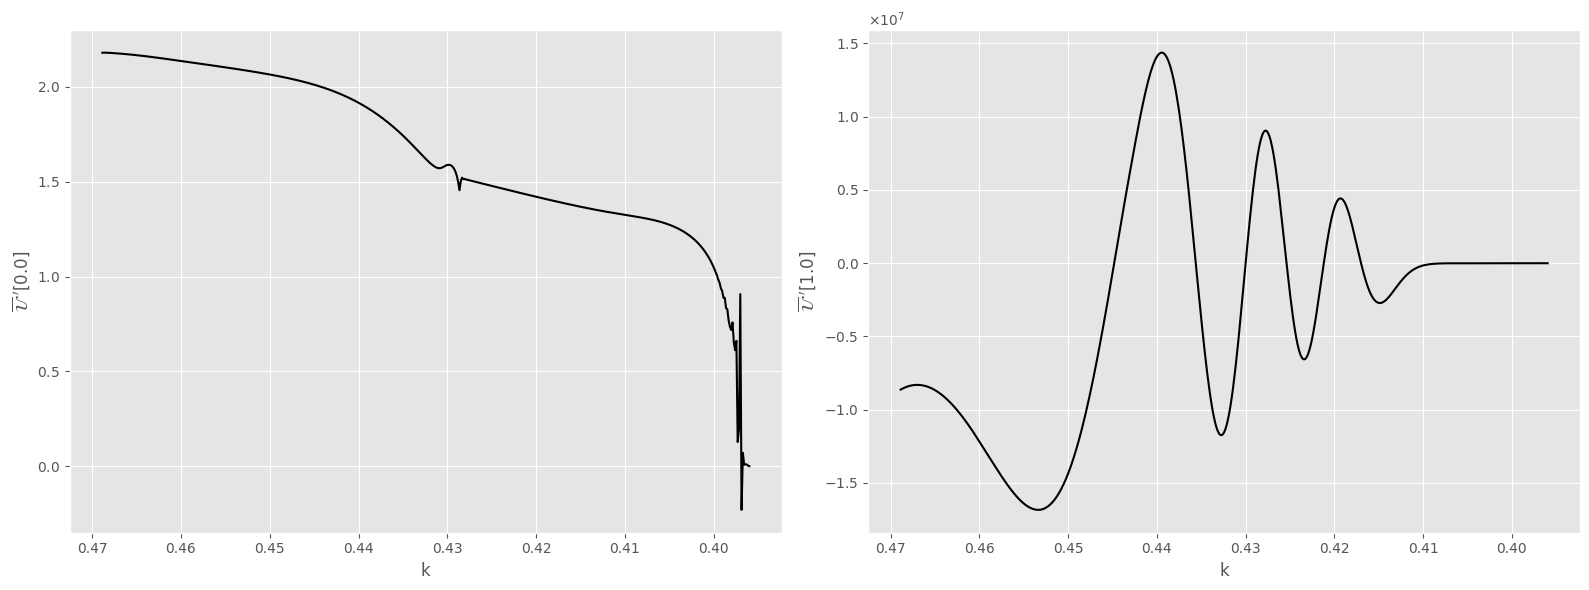

In [22]:
# Visualize the evolution of the field in a given position
t = []
y_0 = []
y_1 = []
for time, field in storage.items():

    # Collect data
    t.append(time)
    y_0.append(field.data[0])
    y_1.append(field.data[-1])
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].plot(t, y_0, 'k-')
ax[0].set_xlabel('k')
ax[0].invert_xaxis()
ax[0].set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{xinf}]$')
ax[0].ticklabel_format(axis='y',
                       style='sci',
                       scilimits=(0, 0),
                       useMathText=True)
ax[1].plot(t, y_1, 'k-')
ax[1].set_xlabel('k')
ax[1].invert_xaxis()
ax[1].set_ylabel(rf'$\overline{{\mathcal{{U}}}}^{{~\prime}}[{xsup}]$')
ax[1].ticklabel_format(axis='y',
                       style='sci',
                       scilimits=(0, 0),
                       useMathText=True)
plt.tight_layout()
plt.show()
plt.close(fig)
